In [ ]:
!pip install wget

# Explain Effect of Regularization using One Feature

In [2]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)

# for the purpose of reproduce
SEED = 0
seed_all(SEED)

## Load Dataset

In [ ]:
!python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv \
    --output delaney-processed.csv

In [4]:
DELANEY_FILE = "delaney-processed.csv"
TASK_COL = 'measured log solubility in mols per litre'
df = pd.read_csv(DELANEY_FILE)
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 1128


## Polynomial Fitting

In [5]:
X = df["Molecular Weight"].values.reshape(-1, 1)
y = df[TASK_COL].values.reshape(-1, 1)

In [6]:
# do 90:10 train:test split
test_size = int(len(X)*0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

In [7]:
def run_gd(X_train, y_train, X_test, y_test, lr, M,
           n_epochs = 20, normalize=True, norm=None, lamda=1):
    theta_list = []
    loss_list = []
    loss_test_list = []

    poly_features = PolynomialFeatures(degree=M)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)

    if normalize:
        scaler = StandardScaler()
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_test_poly = scaler.transform(X_test_poly)
    else:
        scaler = None

    X_train_poly = np.hstack([np.ones((X_train_poly.shape[0], 1)), X_train_poly])
    X_test_poly = np.hstack([np.ones((X_test_poly.shape[0], 1)), X_test_poly])
    theta = np.zeros(X_train_poly.shape[1]).reshape(-1, 1)
    # theta = np.random.randn(X_train_poly.shape[1]).reshape(-1, 1)

    # gd fit
    for _ in range(n_epochs):
        theta_list.append(copy.deepcopy(theta))

        y_pred = X_train_poly @ theta
        loss = np.mean((y_pred - y_train).reshape(-1)**2)
        loss_list.append(loss)
        grad = 2*X_train_poly.T @ (X_train_poly @ theta - y_train) / y_train.shape[0]
        if norm is None:
            grad = grad
        elif norm == "l1":
            grad += lamda*np.sign(theta)
        elif norm == "l2":
            grad += lamda*2*theta
        else:
            raise NotImplementedError(f"Norm {norm} is not valid normalization method")

        theta = theta - lr * grad


        # predict and calculate rmse of test dataset
        y_test_pred = X_test_poly @ theta
        loss_test = np.mean((y_test_pred-y_test)**2)
        loss_test_list.append(loss_test)

    return theta_list, loss_list, loss_test_list, scaler

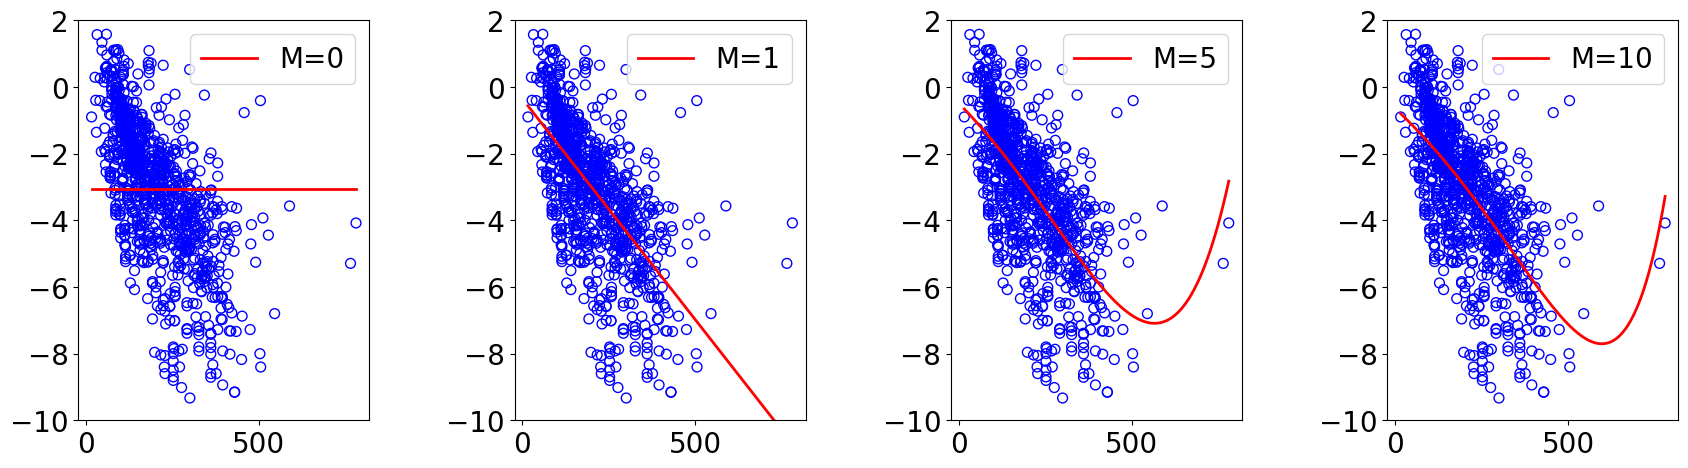

In [8]:
lr = 5e-2
n_epochs = 50
normalize = True
norm = None # regularization in GD


orders = [0, 1, 5, 10]
results = {}

ncols = 4
nrows = len(orders)//ncols if len(orders)%ncols==0 else len(orders)//ncols+1
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axs = axs.flatten()
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)

for idx, M in enumerate(orders):
    theta_list, loss_list, loss_test_list, scaler = run_gd(X_train, y_train, X_test, y_test, lr, M, n_epochs, normalize)
    results[M] = (theta_list, loss_list, loss_test_list, scaler)

    # plot sampled datapoints
    ax = axs[idx]
    ax.scatter(X_train, y_train,
                s=50, marker='o', facecolors='none', edgecolor="blue")

    # plot fitting curve
    poly_features = PolynomialFeatures(degree=M)
    x_lin = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    x_lin_poly = poly_features.fit_transform(x_lin)
    if normalize:
        x_lin_poly_norm = scaler.transform(x_lin_poly)
    else:
        x_lin_poly_norm = x_lin_poly
    x_lin_poly_norm = np.hstack([np.ones((x_lin_poly_norm.shape[0], 1)), x_lin_poly_norm])
    y_lin_pred = x_lin_poly_norm @ theta_list[-1]
    ax.plot(x_lin.reshape(-1), y_lin_pred.reshape(-1), "red", label=f"M={M}")

    ax.set_ylim(-10, 2)
    # ax.set_xlabel("Molecular Weight")
    # ax.set_ylabel("log solubility (mol/L)")
    ax.legend(loc="upper right")

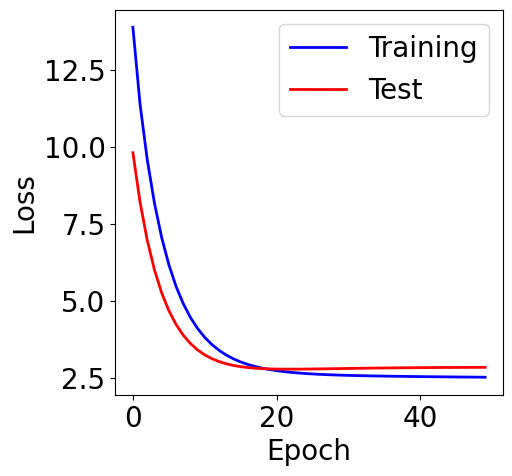

In [9]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue", label="Training")
ax.plot(loss_test_list, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [10]:
def V(xx, yy, X_train, y_train, normalize=True):
    losses = []
    theta = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    if normalize:
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
    else:
        scaler = None
    X_train_norm = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])

    for i in range(theta.shape[0]):
        y_pred = X_train_norm @ theta[i].reshape(-1, 1)
        loss = np.mean((y_pred - y_train).reshape(-1)**2)
        losses.append(loss)
    return np.array(losses)

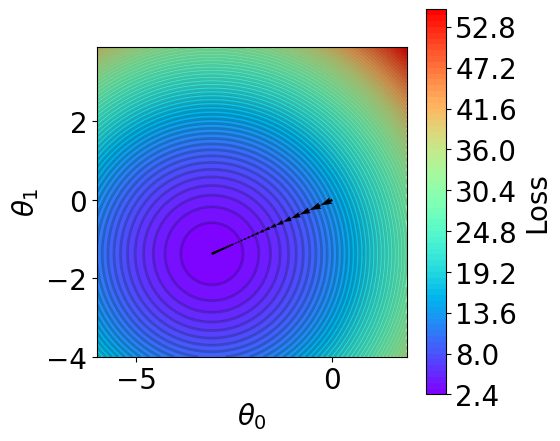

In [11]:
t1 = np.arange(-6, 2, 1e-1)
t2 = np.arange(-4, 4, 1e-1)
xx, yy = np.meshgrid(t1, t2)
z = V(xx.ravel(), yy.ravel(), X_train, y_train).reshape(len(t2), -1)


fig,ax = plt.subplots(1,1,figsize=(5,5))

# z = np.ma.masked_greater(z, 10)
n_levels = 75
c = ax.contourf(t1, t2, z, cmap='rainbow', levels=n_levels, zorder=1)
ax.contour(t1,t2, z, levels=n_levels, zorder=1, colors='black', alpha=0.2)
cb = fig.colorbar(c)
cb.set_label("Loss")

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))


# plot trajectory
theta_list = results[1][0]
for i in range(len(theta_list)-1):
    from_point = (theta_list[i][0], theta_list[i][-1])
    to_point = (theta_list[i+1][0], theta_list[i+1][-1])
    plt.quiver(from_point[0], from_point[1], # from point
               to_point[0]-from_point[0], to_point[1]-from_point[1], # to point
               angles="xy", scale_units="xy", scale=1, color="black",
               linewidth=1.5)

ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_aspect("equal")

## L2 Norm

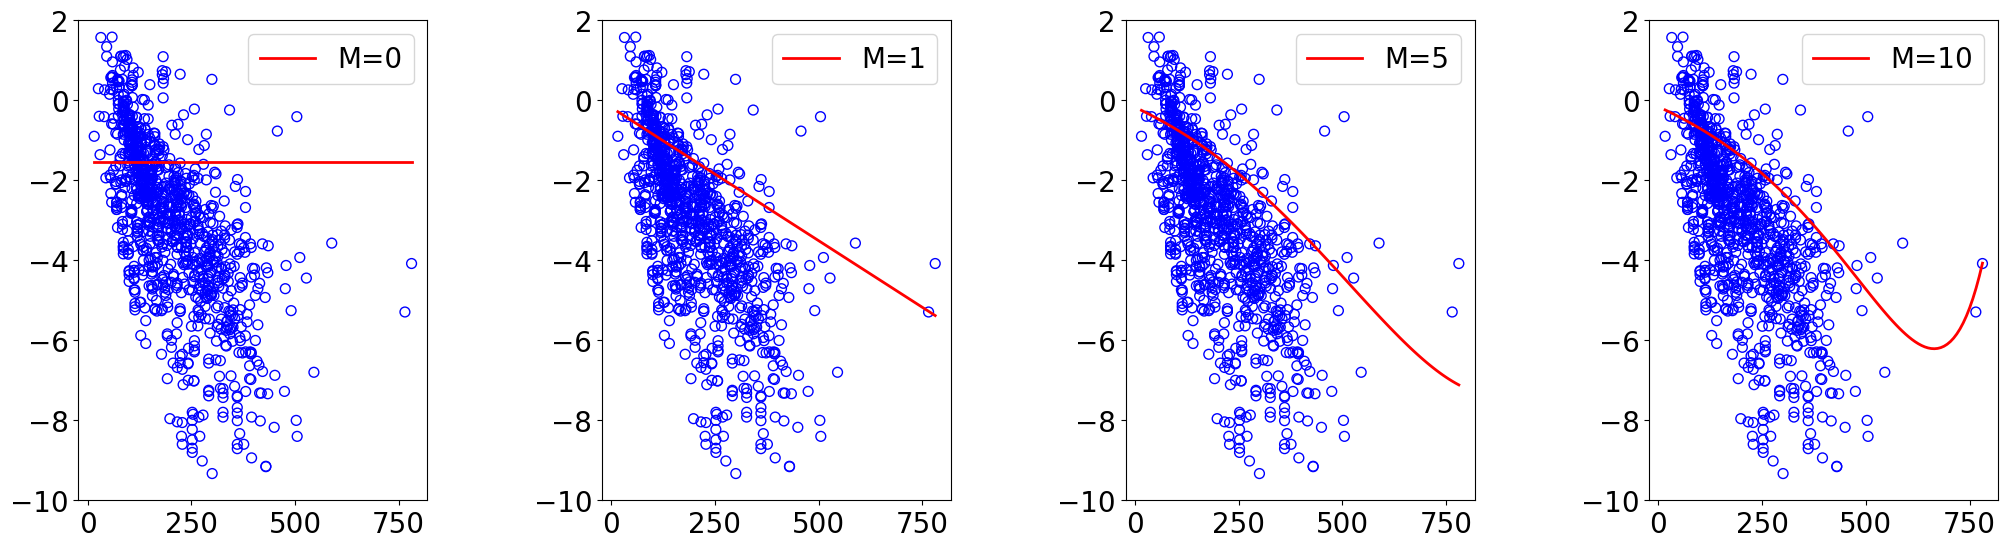

In [12]:
lr = 5e-2
n_epochs = 50
normalize = True
norm = "l2" # regularization in GD
lamda = 1

results = {}

fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
axs = axs.flatten()
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)

for idx, M in enumerate(orders):
    theta_list, loss_list, loss_test_list, scaler = run_gd(X_train, y_train, X_test, y_test,
                                                           lr, M, n_epochs, normalize, norm=norm, lamda=lamda)
    results[M] = (theta_list, loss_list, loss_test_list, scaler)

    # plot sampled datapoints
    ax = axs[idx]
    ax.scatter(X_train, y_train,
                s=50, marker='o', facecolors='none', edgecolor="blue")

    # plot fitting curve
    poly_features = PolynomialFeatures(degree=M)
    x_lin = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    x_lin_poly = poly_features.fit_transform(x_lin)
    if normalize:
        x_lin_poly_norm = scaler.transform(x_lin_poly)
    else:
        x_lin_poly_norm = x_lin_poly
    x_lin_poly_norm = np.hstack([np.ones((x_lin_poly_norm.shape[0], 1)), x_lin_poly_norm])
    y_lin_pred = x_lin_poly_norm @ theta_list[-1]
    ax.plot(x_lin.reshape(-1), y_lin_pred.reshape(-1), "red", label=f"M={M}")

    ax.set_ylim(-10, 2)
    # ax.set_xlabel("Normalized Molecular Weight")
    # ax.set_ylabel("log solubility (mol/L)")
    ax.legend(loc="upper right")

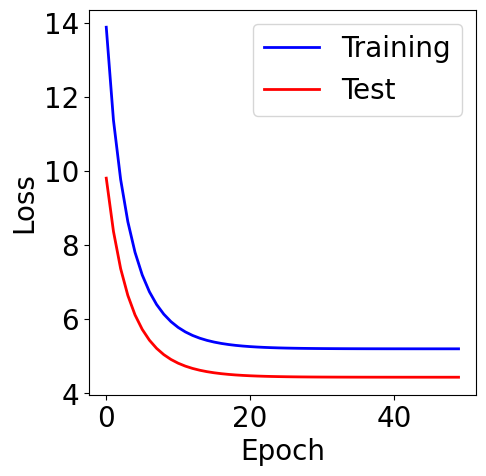

In [13]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue", label="Training")
ax.plot(loss_test_list, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [14]:
def V(xx, yy, X_train, y_train, normalize=True, norm=None, lamda=1):
    losses = []
    theta = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    if normalize:
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
    else:
        scaler = None
    X_train_norm = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])

    for i in range(theta.shape[0]):
        y_pred = X_train_norm @ theta[i].reshape(-1, 1)
        loss = np.mean((y_pred - y_train).reshape(-1)**2)
        if norm is None:
            loss = loss
        elif norm == "l1":
            loss += lamda*np.sum(np.abs(theta[i]))
        elif norm == "l2":
            loss += lamda*np.sum(theta[i]**2)
        else:
            raise NotImplementedError(f"Norm {norm} is not supported")
        losses.append(loss)
    return np.array(losses)

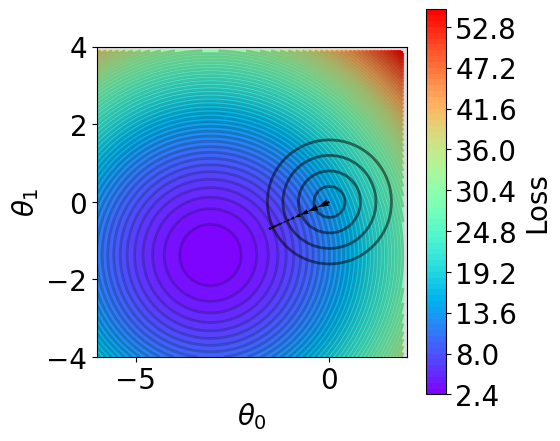

In [15]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

# plot contour
t1 = np.arange(-6, 2, 1e-1)
t2 = np.arange(-4, 4, 1e-1)
xx, yy = np.meshgrid(t1, t2)
z = V(xx.ravel(), yy.ravel(), X_train, y_train, norm=None)
z = z.reshape(len(t2), -1)

n_levels = 75
c = ax.contourf(t1, t2, z, cmap='rainbow', levels=n_levels, zorder=1)
ax.contour(t1,t2, z, levels=n_levels, zorder=1, colors='black', alpha=0.2)
cb = fig.colorbar(c)
cb.set_label("Loss")

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))


# plot l2
x = np.linspace(-6, 2, 100)
y = np.linspace(-4, 4, 100)
xx, yy = np.meshgrid(x, y)
zz = np.sqrt(xx**2 + yy**2)
mask = xx**2 + yy**2 > 4
zz_masked = np.ma.masked_where(mask, zz)
n_levels = 5
# ax.contourf(xx, yy, zz_masked, levels=n_levels, zorder=1, alppha=0.2)
ax.contour(xx, yy, zz_masked, levels=n_levels,
                     zorder=1, colors='black', alpha=0.5)

# plot trajectory
theta_list = results[1][0]
for i in range(len(theta_list)-1):
    from_point = (theta_list[i][0], theta_list[i][-1])
    to_point = (theta_list[i+1][0], theta_list[i+1][-1])
    plt.quiver(from_point[0], from_point[1], # from point
               to_point[0]-from_point[0], to_point[1]-from_point[1], # to point
               angles="xy", scale_units="xy", scale=1, color="black",
               linewidth=1.5)

ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_aspect("equal")

## L1 Norm

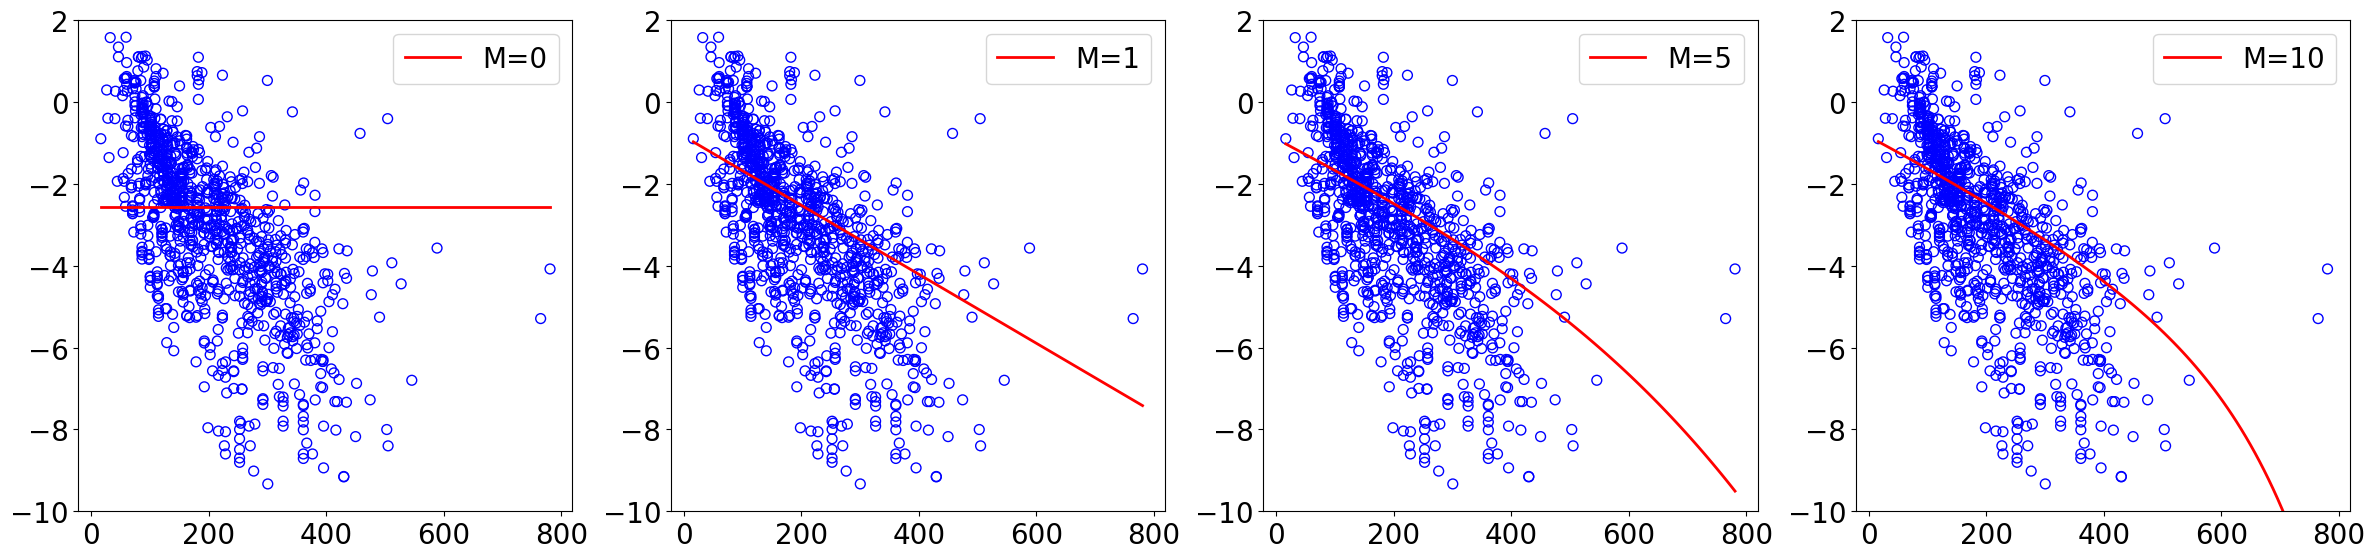

In [16]:
lr = 5e-2
n_epochs = 50
normalize = True
norm = "l1" # regularization in GD
lamda = 1

results = {}

fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
axs = axs.flatten()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)

for idx, M in enumerate(orders):
    theta_list, loss_list, loss_test_list, scaler = run_gd(X_train, y_train, X_test, y_test,
                                                           lr, M, n_epochs, normalize, norm=norm, lamda=lamda)
    results[M] = (theta_list, loss_list, loss_test_list, scaler)

    # plot sampled datapoints
    ax = axs[idx]
    ax.scatter(X_train, y_train,
                s=50, marker='o', facecolors='none', edgecolor="blue")

    # plot fitting curve
    poly_features = PolynomialFeatures(degree=M)
    x_lin = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    x_lin_poly = poly_features.fit_transform(x_lin)
    if normalize:
        x_lin_poly_norm = scaler.transform(x_lin_poly)
    else:
        x_lin_poly_norm = x_lin_poly
    x_lin_poly_norm = np.hstack([np.ones((x_lin_poly_norm.shape[0], 1)), x_lin_poly_norm])
    y_lin_pred = x_lin_poly_norm @ theta_list[-1]
    ax.plot(x_lin.reshape(-1), y_lin_pred.reshape(-1), "red", label=f"M={M}")

    ax.set_ylim(-10, 2)
    # ax.set_xlabel("Normalized Molecular Weight")
    # ax.set_ylabel("log solubility (mol/L)")
    ax.legend(loc="upper right")

plt.tight_layout()

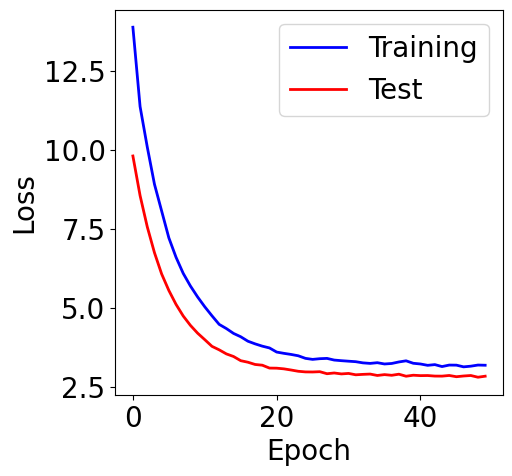

In [17]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue", label="Training")
ax.plot(loss_test_list, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [18]:
def V(xx, yy, X_train, y_train, normalize=True, norm=None, lamda=1):
    losses = []
    theta = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    if normalize:
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
    else:
        scaler = None
    X_train_norm = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])

    for i in range(theta.shape[0]):
        y_pred = X_train_norm @ theta[i].reshape(-1, 1)
        loss = np.mean((y_pred - y_train).reshape(-1)**2)
        if norm is None:
            loss = loss
        elif norm == "l1":
            loss += lamda*np.sum(np.abs(theta[i]))
        elif norm == "l2":
            loss += lamda*np.sum(theta[i]**2)
        else:
            raise NotImplementedError(f"Norm {norm} is not supported")
        losses.append(loss)
    return np.array(losses)

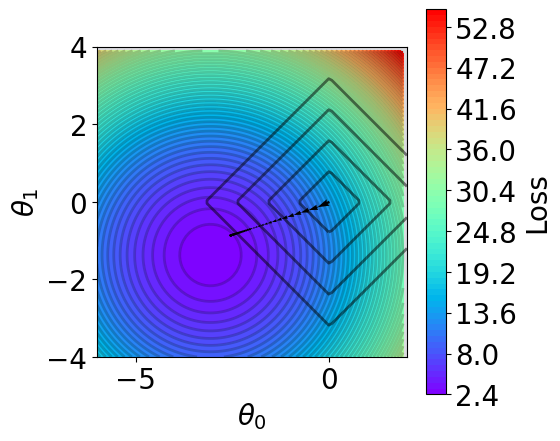

In [19]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

# plot contour
t1 = np.arange(-6, 2, 1e-1)
t2 = np.arange(-4, 4, 1e-1)
xx, yy = np.meshgrid(t1, t2)
z = V(xx.ravel(), yy.ravel(), X_train, y_train, norm=None)
z = z.reshape(len(t2), -1)

n_levels = 75
c = ax.contourf(t1, t2, z, cmap='rainbow', levels=n_levels, zorder=1)
ax.contour(t1,t2, z, levels=n_levels, zorder=1, colors='black', alpha=0.2)
cb = fig.colorbar(c)
cb.set_label("Loss")

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))


# plot l2
x = np.linspace(-6, 2, 100)
y = np.linspace(-4, 4, 100)
xx, yy = np.meshgrid(x, y)
zz = np.abs(xx) + np.abs(yy)
mask = np.abs(xx) + np.abs(yy) > 4
zz_masked = np.ma.masked_where(mask, zz)
n_levels = 5
ax.contour(xx, yy, zz_masked, levels=n_levels,
                     zorder=1, colors='black', alpha=0.5)

# plot trajectory
theta_list = results[1][0]
for i in range(len(theta_list)-1):
    from_point = (theta_list[i][0], theta_list[i][-1])
    to_point = (theta_list[i+1][0], theta_list[i+1][-1])
    plt.quiver(from_point[0], from_point[1], # from point
               to_point[0]-from_point[0], to_point[1]-from_point[1], # to point
               angles="xy", scale_units="xy", scale=1, color="black",
               linewidth=1.5)

ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_aspect("equal")